In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [15]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

In [8]:
import missingno as msno
import warnings

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
age_gender_info = pd.read_csv('./age_gender_info.csv')
submission = pd.read_csv('./sample_submission.csv')

In [5]:
# 문제있는 아파트 코드 삭제
train = train[~train["단지코드"].isin(['C2675','C2335','C1327'])]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2952 entries, 0 to 2951
Data columns (total 15 columns):
단지코드                            2952 non-null object
총세대수                            2952 non-null int64
임대건물구분                          2952 non-null object
지역                              2952 non-null object
공급유형                            2952 non-null object
전용면적                            2952 non-null float64
전용면적별세대수                        2952 non-null int64
공가수                             2952 non-null float64
자격유형                            2952 non-null object
임대보증금                           2383 non-null object
임대료                             2383 non-null object
도보 10분거리 내 지하철역 수(환승노선 수 반영)    2741 non-null float64
도보 10분거리 내 버스정류장 수              2948 non-null float64
단지내주차면수                         2952 non-null float64
등록차량수                           2952 non-null float64
dtypes: float64(6), int64(2), object(7)
memory usage: 369.0+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
단지코드                            1022 non-null object
총세대수                            1022 non-null int64
임대건물구분                          1022 non-null object
지역                              1022 non-null object
공급유형                            1022 non-null object
전용면적                            1022 non-null float64
전용면적별세대수                        1022 non-null int64
공가수                             1022 non-null float64
자격유형                            1020 non-null object
임대보증금                           842 non-null object
임대료                             842 non-null object
도보 10분거리 내 지하철역 수(환승노선 수 반영)    980 non-null float64
도보 10분거리 내 버스정류장 수              1022 non-null float64
단지내주차면수                         1022 non-null float64
dtypes: float64(5), int64(2), object(7)
memory usage: 111.9+ KB


#### 1.1 Null Data 확인

In [9]:
for col in train.columns:
    msg = 'column: {:>10}\t percent of NaN Value {:.2f}%'.format(col,100 * train[col].isnull().sum() / train[col].shape[0])
    print(msg)

column:       단지코드	 percent of NaN Value 0.00%
column:       총세대수	 percent of NaN Value 0.00%
column:     임대건물구분	 percent of NaN Value 0.00%
column:         지역	 percent of NaN Value 0.00%
column:       공급유형	 percent of NaN Value 0.00%
column:       전용면적	 percent of NaN Value 0.00%
column:   전용면적별세대수	 percent of NaN Value 0.00%
column:        공가수	 percent of NaN Value 0.00%
column:       자격유형	 percent of NaN Value 0.00%
column:      임대보증금	 percent of NaN Value 19.28%
column:        임대료	 percent of NaN Value 19.28%
column: 도보 10분거리 내 지하철역 수(환승노선 수 반영)	 percent of NaN Value 7.15%
column: 도보 10분거리 내 버스정류장 수	 percent of NaN Value 0.14%
column:    단지내주차면수	 percent of NaN Value 0.00%
column:      등록차량수	 percent of NaN Value 0.00%


In [10]:
for col in test.columns:
    msg = 'column: {:>10}\t percent of NaN Value {:.2f}%'.format(col,100 * test[col].isnull().sum() / test[col].shape[0])
    print(msg)

column:       단지코드	 percent of NaN Value 0.00%
column:       총세대수	 percent of NaN Value 0.00%
column:     임대건물구분	 percent of NaN Value 0.00%
column:         지역	 percent of NaN Value 0.00%
column:       공급유형	 percent of NaN Value 0.00%
column:       전용면적	 percent of NaN Value 0.00%
column:   전용면적별세대수	 percent of NaN Value 0.00%
column:        공가수	 percent of NaN Value 0.00%
column:       자격유형	 percent of NaN Value 0.20%
column:      임대보증금	 percent of NaN Value 17.61%
column:        임대료	 percent of NaN Value 17.61%
column: 도보 10분거리 내 지하철역 수(환승노선 수 반영)	 percent of NaN Value 4.11%
column: 도보 10분거리 내 버스정류장 수	 percent of NaN Value 0.00%
column:    단지내주차면수	 percent of NaN Value 0.00%


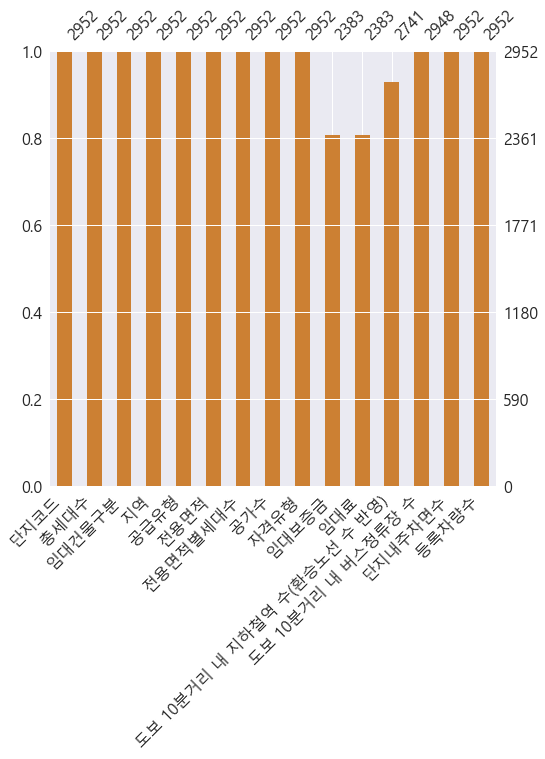

In [18]:
msno.bar(df=train.iloc[:,:],figsize=(8,8), color=(0.8,0.5,0.2))

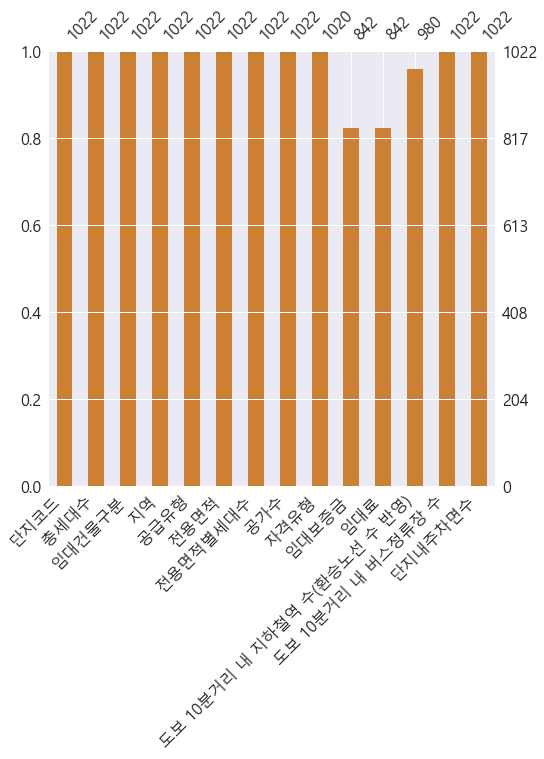

In [19]:
msno.bar(df=test.iloc[:,:],figsize=(8,8), color=(0.8,0.5,0.2))

In [22]:
train.loc[train["임대보증금"]=='-','임대보증금'] = np.nan
test.loc[test["임대보증금"]=='-','임대보증금'] = np.nan
train['임대보증금'] =  train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-','임대료'] = np.nan
test.loc[test.임대료 == '-','임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

#### NULL 값

In [23]:
train[train.임대보증금.isnull()].공급유형.value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

In [24]:
test[test.임대보증금.isnull()].공급유형.value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [25]:
train[train.임대보증금.isnull()].자격유형.value_counts()

D    569
H      8
K      4
Name: 자격유형, dtype: int64

In [26]:
test[test.임대보증금.isnull()].자격유형.value_counts()

D    180
L      4
C      2
Name: 자격유형, dtype: int64

In [27]:
train[train.자격유형.isin(['D', 'H', 'K'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 88 to 2919
Data columns (total 15 columns):
단지코드                            757 non-null object
총세대수                            757 non-null int64
임대건물구분                          757 non-null object
지역                              757 non-null object
공급유형                            757 non-null object
전용면적                            757 non-null float64
전용면적별세대수                        757 non-null int64
공가수                             757 non-null float64
자격유형                            757 non-null object
임대보증금                           176 non-null float64
임대료                             176 non-null float64
도보 10분거리 내 지하철역 수(환승노선 수 반영)    623 non-null float64
도보 10분거리 내 버스정류장 수              757 non-null float64
단지내주차면수                         757 non-null float64
등록차량수                           757 non-null float64
dtypes: float64(8), int64(2), object(5)
memory usage: 94.6+ KB


In [ ]:
test[test.자격유형.isin(['D', 'L', 'C'])].info()

#### 임대보증금,임대료

In [28]:
train[['임대보증금','임대료']] = train[['임대보증금','임대료']].fillna(0)
test[['임대보증금','임대료']] = test[['임대보증금','임대료']].fillna(0)

#### 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수

In [29]:
subway_null_codes = train[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.unique()
train.loc[train.단지코드.isin(subway_null_codes),'도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(dropna=False)

NaN    211
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

In [30]:
subway_null_codes = test[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.unique()
test.loc[test.단지코드.isin(subway_null_codes),'도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(dropna=False)

NaN    42
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

In [31]:
bus_null_codes = train[train['도보 10분거리 내 버스정류장 수'].isnull()].단지코드.unique()
train.loc[train.단지코드.isin(bus_null_codes),'도보 10분거리 내 버스정류장 수'].value_counts(dropna=False)

NaN    4
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [32]:
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)','도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### 자격유형

In [33]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


In [34]:
test[test.단지코드=='C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [35]:
test.loc[test.단지코드.isin(['C2411'])& test.자격유형.isnull(),'자격유형'] = 'A'

In [36]:
test[test.단지코드=='C2253'].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,0.0,0.0,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,0.0,0.0,0.0,2.0,173.0


In [37]:
test.loc[test.단지코드.isin(['C2253'])& test.자격유형.isnull(),'자격유형'] = 'C'

In [43]:
train.duplicated

<bound method DataFrame.duplicated of        단지코드  총세대수 임대건물구분       지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
0     C2483   900    아파트     경상북도  국민임대  39.72       134  38.0    A   
1     C2483   900    아파트     경상북도  국민임대  39.72        15  38.0    A   
2     C2483   900    아파트     경상북도  국민임대  51.93       385  38.0    A   
3     C2483   900    아파트     경상북도  국민임대  51.93        15  38.0    A   
4     C2483   900    아파트     경상북도  국민임대  51.93        41  38.0    A   
5     C2483   900    아파트     경상북도  국민임대  51.95        89  38.0    A   
6     C2483   900    아파트     경상북도  국민임대  51.95       135  38.0    A   
7     C2483   900    아파트     경상북도  국민임대  59.88        86  38.0    A   
8     C2515   545    아파트     경상남도  국민임대  33.48       276  17.0    A   
9     C2515   545    아파트     경상남도  국민임대  39.60        60  17.0    A   
10    C2515   545    아파트     경상남도  국민임대  39.60        20  17.0    A   
11    C2515   545    아파트     경상남도  국민임대  46.90        38  17.0    A   
12    C2515   545    아파트     경상남도  국민임대

In [42]:
train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

단지코드                             423
총세대수                             423
임대건물구분                           456
지역                               423
공급유형                             488
전용면적                            1898
전용면적별세대수                        2230
공가수                              423
자격유형                             510
임대보증금                           1277
임대료                             1289
도보 10분거리 내 지하철역 수(환승노선 수 반영)     423
도보 10분거리 내 버스정류장 수               423
단지내주차면수                          423
등록차량수                            423
dtype: int64

#### 하나의 단지코드에 하나의 값만 존재하는 변수들

In [44]:
unique_cols = ['총세대수','지역','공가수',
              '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
              '도보 10분거리 내 버스정류장 수',
              '단지내주차면수','등록차량수']

In [45]:
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [46]:
train_agg

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0
C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0
C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0
C1244,1722,경기도,10.0,0.0,10.0,1483.0,1804.0
C1171,624,대전광역시,13.0,0.0,5.0,634.0,700.0
C2073,361,강원도,13.0,0.0,5.0,288.0,301.0


In [47]:
test_agg

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
단지코드,,,,,,
C1072,754,경기도,14.0,0.0,2.0,683.0
C1128,1354,경기도,9.0,0.0,3.0,1216.0
C1456,619,부산광역시,18.0,0.0,16.0,547.0
C1840,593,전라북도,7.0,0.0,3.0,543.0
C1332,1297,경기도,11.0,0.0,2.0,1112.0
C1563,1974,경기도,15.0,0.0,6.0,1696.0
C1794,1349,전라북도,25.0,0.0,2.0,1098.0
C1640,533,전라북도,17.0,0.0,1.0,470.0
C1377,470,경상남도,18.0,0.0,4.0,384.0


In [50]:
train.drop_duplicates(['단지코드','임대건물구분']).assign(counter=1).pivot(index='단지코드',columns='임대건물구분',values='counter').fillna(0)

임대건물구분,상가,아파트
단지코드,,
C1000,0.0,1.0
C1004,1.0,1.0
C1005,0.0,1.0
C1013,0.0,1.0
C1014,0.0,1.0
C1015,0.0,1.0
C1017,0.0,1.0
C1022,0.0,1.0
C1024,0.0,1.0
